# Preparation for the final project

In [120]:
import requests
import json
import nltk
import collections
import pandas as pd
import numpy as np
import spacy
import en_core_web_lg
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt

In [2]:
nlp = en_core_web_lg.load()

## Collect the corpus needed

In [3]:
def getTokens(lines):
    tokens = []
    for line in lines:
        lineDoc = nlp(line)
        tokens.extend([token.text.lower() for token in lineDoc if token.text.isalpha])
    return tokens

In [4]:
# get all information I need from one author
def getAuthorInf(name):
    authorInf = {}
    url = 'http://poetrydb.org/author/' + name
    text = requests.get(url).json()
    authorInf['content'] = [each['lines'] for each in text]
    authorInf['linecount'] = sum([int(text[i]['linecount']) for i in range(len(text))])
    authorInf['title'] = [each['title'] for each in text]
    authorInf['contentUnion'] = []
    for content in authorInf['content']:
        authorInf['contentUnion'].extend(content)
    return authorInf

In [5]:
# make the information of the lists of authors into one
def getAuthorUnionInf(nameList):
    authorUnionInf = {'content': [],
                     'title': [],
                     'contentUnion': [],
                     'linecount': 0}
    for name in nameList:
        authorInf = getAuthorInf(name)
        # 'content' save lines in different pieces seperately. But no seperation from different author
        authorUnionInf['content'].extend(authorInf['content'])
        # 'contentUnion' is just a collection of pure lines. No boundaries among pieces
        authorUnionInf['contentUnion'].extend(authorInf['contentUnion'])
        authorUnionInf['title'].extend(authorInf['title'])
        authorUnionInf['linecount'] += authorInf['linecount']
    return authorUnionInf

In [6]:
# Gather information of these two kinds
posNames = ['George Gordon, Lord Byron', 'John Keats', 'Percy Bysshe Shelley']
posInf = getAuthorUnionInf(posNames)
negNames = ['William Blake', 'Samuel Coleridge', 'William Wordsworth']
negInf = getAuthorUnionInf(negNames)

In [7]:
stops = nltk.corpus.stopwords.words('english')

# Color usage according to the tense

In [8]:
# get the ratio of the specific word to length of tokens
# This function is not used for now
def getWordRatio(word, allTokens):
    return len([w for w in allTokens if w == word])/len(allTokens)

In [9]:
# categorize the lines into three tense
# return a dict of four keys: past, present, future, unknown
'''
VB     Verb, base form
VBD     Verb, past tense
VBG     Verb, gerund or present participle
VBN     Verb, past participle
VBP     Verb, non-3rd person singular present
VBZ     Verb, 3rd person singular present
'''
def classifyTenseOfLines(lines):
    pastPos = ['VBD', 'VBN']
    presentPos = ['VBG', 'VB', 'VBP', 'VBZ']
    futureWord = ['will', 'would', 'could', 'shall', 'won\'t', 'shan\'t']
    tenseLineDict = {'past': [], 'present':[], 'future':[], 'unknown':[]}
    
    for line in lines:
        conti = False
        tokens = nltk.word_tokenize(line)
        wordPos = nltk.pos_tag(tokens)
        words = [w[0] for w in wordPos]
        poses = [p[1] for p in wordPos]
        for pos in pastPos:
            if pos in poses:
                tenseLineDict['past'].append(line)
                conti = True
                break
        if conti:
            continue
        for word in futureWord:
            if word in words:
                tenseLineDict['future'].append(line)
                conti = True
        if conti:
            continue
        for pos in presentPos:
            if pos in poses:
                tenseLineDict['present'].append(line)
                conti = True
                break
        if conti:
            continue
        if not conti:
            tenseLineDict['unknown'].append(line)
    return tenseLineDict

In [10]:
negTense = classifyTenseOfLines(negInf['contentUnion'])
posTense = classifyTenseOfLines(posInf['contentUnion'])

In [11]:
colorNode = wn.synset('color.n.01')

In [12]:
def getDepthNHypernym(word, n):
    if word.max_depth() > n+1:
        if type(word.hypernyms()) is list and len(word.hypernyms()) > 0:
            return getDepthNHypernym(word.hypernyms()[0], n)
    return word.hypernyms()

In [13]:
def getLinesColor(lines):
    colorInText = []
    count = 1
    for line in lines:
        tokens = nltk.word_tokenize(line)
        count += len(tokens)
        for token in tokens:
            token = token.lower()
            syns = wn.synsets(token)
            for item in syns:
                if len(getDepthNHypernym(item, 5)) > 0:
                    if getDepthNHypernym(item, 5)[0] == colorNode:
                        colorInText.append(item._name.split('.')[0])
    return colorInText, len(colorInText)/count

In [14]:
# negative
negColorPastList, negColorPastN = getLinesColor(negTense['past'])
negColorPresentList, negColorPresentN = getLinesColor(negTense['present'])
negColorFutureList, negColorFutureN = getLinesColor(negTense['future'])
negMostColorPast = collections.Counter(negColorPastList).most_common(1)[0]
negMostColorPresent = collections.Counter(negColorPresentList).most_common(1)[0]
negMostColorFuture = collections.Counter(negColorFutureList).most_common(1)[0]

negMostColorWord = [negMostColorPast[0], negMostColorPresent[0], negMostColorFuture[0]]
negTenseColorCount = [negColorPastN, negColorPresentN, negColorFutureN]
negMostColorRatio = [negMostColorPast[1]/len(negTense['past']), negMostColorPresent[1]/len(negTense['present']), negMostColorFuture[1]/len(negTense['future'])]

In [15]:
# positive
posColorPastList, posColorPastN = getLinesColor(posTense['past'])
posColorPresentList, posColorPresentN = getLinesColor(posTense['present'])
posColorFutureList, posColorFutureN = getLinesColor(posTense['future'])
posMostColorPast = collections.Counter(posColorPastList).most_common(1)[0]
posMostColorPresent = collections.Counter(posColorPresentList).most_common(1)[0]
posMostColorFuture = collections.Counter(posColorFutureList).most_common(1)[0]

posMostColorWord = [posMostColorPast[0], posMostColorPresent[0], posMostColorFuture[0]]
posTenseColorCount = [posColorPastN, posColorPresentN, posColorFutureN]
posMostColorRatio = [posMostColorPast[1]/len(posTense['past']), posMostColorPresent[1]/len(posTense['present']), posMostColorFuture[1]/len(posTense['future'])]

In [16]:
posnegColorWord = []
posnegColorRatio = []
for i in range(3):
    posnegColorWord.extend([posMostColorWord[i], negMostColorWord[i]])
    posnegColorRatio.extend([posTenseColorCount[i], negTenseColorCount[i]])
data = {'Color': posnegColorWord,
       'Ratio': posnegColorRatio}
mostColorDf = pd.DataFrame(data, index = ['neg_past', 'neg_present', 'neg_future', 'pos_past', 'pos_present', 'pos_future'])
mostColorDf

,Color,Ratio
neg_past,rose,0.003666
neg_present,rose,0.007774
neg_future,shade,0.003203
pos_past,green,0.004154
pos_present,amber,0.002008
pos_future,white,0.002747


In [17]:
negTenseColorCount = [-r for r in negTenseColorCount]

Text(3.8, -0.0012, 'future')

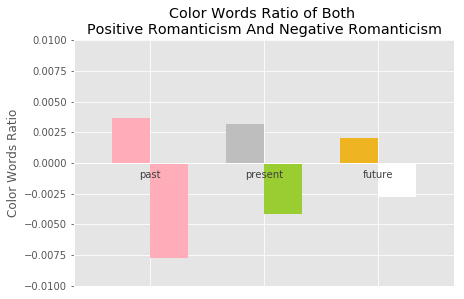

In [33]:
xlabel = ['past', 'present', 'future']
xmid = [1.0, 2.5, 4.0]
posx = [0.75, 2.25, 3.75]
negx = [1.25, 2.75, 4.25]
negMostColor = ['#FFAEB9', '#9ACD32', '#FFFFFF']
posMostColor = ['#FFAEB9', '#BEBEBE', '#EEB422']

fig, ax = plt.subplots()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
plt.style.use('ggplot')
ax.set(ylim=[-0.01, 0.01], xlim = [0,5], xlabel='', 
       ylabel='Color Words Ratio') 
plt.title('Color Words Ratio of Both \nPositive Romanticism And Negative Romanticism')
plt.bar(posx, posTenseColorCount, width=0.5, color = posMostColor)
plt.bar(negx, negTenseColorCount, width=0.5, color = negMostColor)
ax.set_xticks(xmid)
ax.set_xticklabels(['','',''])
plt.annotate('past', xy = (0.85, -0.0012), color = '#3F3F3F')
plt.annotate('present', xy = (2.25, -0.0012), color = '#3F3F3F')
plt.annotate('future', xy = (3.80, -0.0012), color = '#3F3F3F')

In [19]:
negMostColorWord

['rose', 'green', 'white']

In [20]:
posMostColorWord

['rose', 'shade', 'amber']

# Rhyme

In [21]:
arpabet = nltk.corpus.cmudict.dict()
allWords = arpabet.keys()

In [22]:
def getLastSound(line):
    line = line.lower()
    words = nltk.word_tokenize(line)
    words.reverse()
    lastWord = 0
    for word in words:
        if word.isalpha():
            lastWord = word
            break
    if lastWord not in allWords:
        return 0
    return arpabet[lastWord][-1][-1]

In [23]:
# get all of the rhythm sound of this collection of sounds
def getAllRhymeSound(lines):
    exceptionLines = []
    sounds = []
    for line in lines:
        sound = getLastSound(line)
        if sound == 0:
            exceptionLines.append(line)
        else:
            sounds.append(sound)
    return sounds, exceptionLines

In [24]:
posSounds, posExceptionLines = getAllRhymeSound(posInf['contentUnion'])
negSounds, negExceptionLines = getAllRhymeSound(negInf['contentUnion'])
posMostSounds = collections.Counter(posSounds).most_common(10)
negMostSounds = collections.Counter(negSounds).most_common(10)

In [25]:
data = {'pos_rhyme': posMostSounds,
            'neg_rhyme': negMostSounds}
pd.DataFrame(data)

,pos_rhyme,neg_rhyme
0,"(T, 12510)","(D, 335)"
1,"(N, 12419)","(T, 299)"
2,"(D, 12101)","(N, 274)"
3,"(Z, 10600)","(Z, 246)"
4,"(S, 6960)","(R, 175)"
5,"(R, 6316)","(L, 169)"
6,"(L, 5892)","(S, 141)"
7,"(M, 4613)","(IY1, 115)"
8,"(IY0, 3856)","(EY1, 114)"
9,"(ER0, 3732)","(IY0, 111)"


In [55]:
negMostSoundsText = [s[0] for s in negMostSounds]
posMostSoundsText = [s[0] for s in posMostSounds]
negMostSoundsRatio = [s[1]/negInf['linecount']*100 for s in negMostSounds]
posMostSoundsRatio = [s[1]/posInf['linecount']*100 for s in posMostSounds]

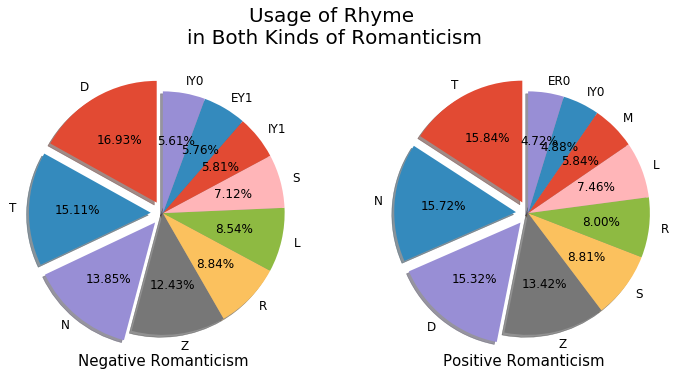

In [119]:
explode = [0.1, 0.1, 0.1] + [0] * 7
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.pie(negMostSoundsRatio, labels = negMostSoundsText, autopct='%1.2f%%', startangle=90, 
        explode=explode, shadow = True, textprops = dict(size = 12));
plt.annotate('Negative Romanticism', xy = (-0.7, -1.25), size = 15)
ax2 = plt.subplot(122)
ax2.pie(posMostSoundsRatio, labels = posMostSoundsText, autopct='%1.2f%%', startangle=90, 
        explode=explode, shadow = True, textprops = dict(size = 12));
plt.suptitle('Usage of Rhyme \nin Both Kinds of Romanticism', size = 20)
plt.annotate('Positive Romanticism', xy = (-0.7, -1.25), size = 15);

# Analysis of Emotional Changes within lines

In [26]:
from nltk.corpus import sentiwordnet as sw 

In [27]:
def getScoresOfLine(line):
    '''
    This function return emotiona fluctuation and objectiveness grade
    We only interest in the grade of adjectives, adverbs and nouns
    '''
    posScores = []
    negScores = []
    objScores = []
    lineDoc = nlp(line)
    
    if len(line) > 0:
        for word in lineDoc:
            synPos =  word.pos_.lower()[0]
            if synPos in ['a', 'v', 'n']:
                synsets = list(sw.senti_synsets(word.lemma_, synPos))
                if (type(synsets) == list) and len(synsets)>0:
                    synset = synsets[0]
                    posScores.append(synset.pos_score())
                    negScores.append(synset.neg_score())
                    objScores.append(synset.obj_score())
        if len(posScores) > 0 and len(objScores) > 0:
            rangeScore = (max(posScores) + max(negScores))/2
            objScore = sum(objScores)/len(objScores)
            return rangeScore, objScore
        elif len(posScores) > 0 and len(objScores) == 0:
            return (max(posScores) + max(negScores))/2, 0
        elif len(posScores) == 0 and len(objScores) > 0:
            return 0, sum(objScores)/len(objScores)
        else:
            return 0, 0
    else:
        return 0, 0

In [130]:
def getScoresOfLines(lines):
    emotionOfLines = [getScoresOfLine(line)[0] for line in lines]
    objOfLines = [getScoresOfLine(line)[1] for line in lines]
    return emotionOfLines, objOfLines

In [131]:
negEmotion, negObj = getScoresOfLines(negInf['contentUnion'])

In [132]:
posEmotion, posObj = getScoresOfLines(posInf['contentUnion'])

Text(0.5, 1.0, 'Objectiveness&Emotional Fluctuation Grades')

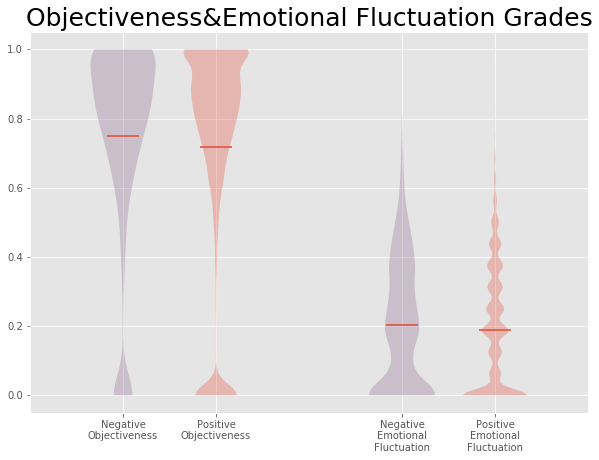

In [193]:
plt.figure(figsize=(10, 7))
ax = plt.subplot(111)
pc = ax.violinplot([negObj, posObj, negEmotion, posEmotion], showmeans=True,
    showextrema=False,
    showmedians=False,positions = [1, 2, 4, 5], widths = 0.7
);
ax.set_xlim([0, 6])
ax.set_xticks([1, 2, 4, 5])
ax.set_xticklabels(['Negative\nObjectiveness', 'Positive\nObjectiveness', 
                    'Negative\nEmotional\nFluctuation', 'Positive\nEmotional\nFluctuation'])
pc['bodies'][0].set_facecolor("#8B668B")
pc['bodies'][2].set_facecolor("#8B668B")
plt.title('Objectiveness&Emotional Fluctuation Grades', fontsize = 25)

In [ ]:
def similarity(a, b):
    return nlp(a).similarity(nlp(b))